一、数据清洗及特征处理

In [2]:
import numpy as np
import pandas as pd

一般情况下，我们得到的数据通常是不干净的，这些数据中有缺失值，或者有一些异常点等，需要经过一定的处理才能继续做后面的分析或建模，所以拿到数据的第一步是进行数据清洗。

数据清洗的内容一般包括检测和取出数据集中的噪声数据、无关数据，处理遗漏数据，去除空白数据和知识背景下的白噪声。通常由五个步骤组成：（1）去除/补全有缺失的数据；（2）去除/修改格式和内容错误的数据；（3）去除/补全逻辑错误的数据；（4）去除不需要的数据；（5）关联性验证

In [92]:
pf = pd.read_csv("train.csv")

1.1处理缺失值：

观察缺失值的方法：对于数值数据，pandas使用浮点值NaN（Not a Number）表示缺失数据。我们称其为哨兵值，可以方便的检测出来。

In [33]:
#对全体数据的特征缺失值个数查看可以用info（）的方法，或者用sum（）统计isnull（）转化后的数据
pf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [43]:
pf.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [15]:
#也可以对某一列单独操作，这里对Cabin列进行查看，先用isnull方法将缺失值转化成True，再统计一下数量
pf.isnull().value_counts(['Cabin'])

Cabin
True     687
False    204
dtype: int64

In [14]:
#也可以针对多列进行联合查询，
pf.isnull().value_counts(['Cabin', 'Age'])

Cabin  Age  
True   False    529
False  False    185
True   True     158
False  True      19
dtype: int64

In [76]:
sum(pf['Age'].isnull())

177

In [77]:
sum(pf['Age']== None)

0

In [78]:
sum(pf['Age']== np.nan)

0

注：在检索空缺值时，除了isnull（）方法，np.nan，None也是可以使用的。但是相比之下，还是isnull()方法更好，因为isnull()可以同时识别np.nan和None类型

In [32]:
#计数时还可以直接采用python的sum函数，并借助len函数求出缺失值占比
missrate = sum(pf.isnull().Cabin)*100 / len(pf)
print("%.2f%%" % missrate)
#外，使用sort_value()方法时NaN的数据会被自动排在列尾

77.10%


完成了对缺失值的观察，就需要进行缺失值的处理了。一般来说，有三种处理方式：舍弃；填充；空置

第一种：丢弃（不使用有缺失值的样本，效果最好，但过于理想化，通常难以保证绝对完整的足够量数据）这种做法优点很突出，简单粗暴，省时省力，知名的数据处理工具pandas中，就专门提供了dropna这种方法。但缺点也很突出，一条宝贵的样本数据，因为沾了点脏东西就被浪费掉了。

第二种：填充均值（为了保证数据完整，要对缺失值进行重新赋值，而一旦赋值出现某种偏向性，就会影响整个样本的整体数据分布，最终必将导致机器学习模型的预测出现某种偏差。）从统计学角度来看，可以更具实际情况，填充均值、众数、中位数等，效果略有区别，不过出发点都是一样的。


第三种：置空（这种方法不是说不在缺失处引入值，而是根据相关数据为这里赋一个相对合理的值，例如说前一个样本的值是7，后一个样本的值是9，中间这个样本出现缺失值了，那自然是填一个8。具体的方法就是插值法和KNN法。）

以上三种基本上就是当前最常见的缺失值处理思路，不过，随着机器学习的普及，第三种方法迎来了自己的进阶版，采用机器学习的方法，譬如神经网络模型，来填补缺失值。一定程度上效果比传统方法都好，且还不会造成样本浪费。理论上来讲，或许用预训练的方法，可以完美实现数据缺失处理。

在处理有缺失的数据时，有两个简单粗暴的方法dropna（）和fillna（）

DataFrame.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

how参数：how='all'将只丢弃全为NA的那些行；thresh参数：假设只想留下一部分观测数据，可以用thresh参数规定范围（默认采用行索引index）

DataFrame.fillna(value=None, method=None, axis=None, inplace=False, limit=None, downcast=None)

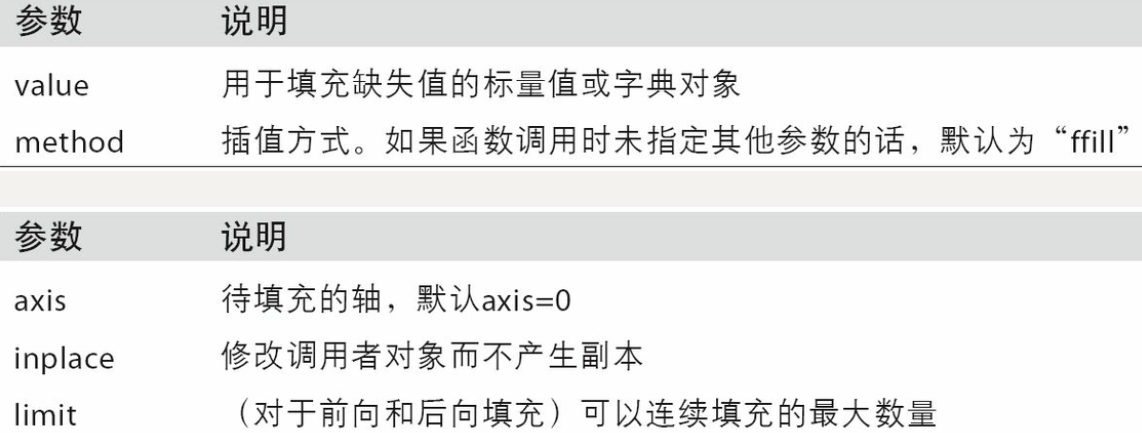

2.处理重复值

In [81]:
#在查询重复值时，DataFrame的duplicated方法返回一个布尔型Series，表示各行是否是重复行（前面出现过的行）
#pf.duplicated().sum()
pf.duplicated().head()

0    False
1    False
2    False
3    False
4    False
dtype: bool

In [82]:
data = pd.DataFrame({'k1': ['one', 'two'] * 3 + ['two'], 'k2': [1, 1, 2, 3, 3, 4, 4]})
data

,k1,k2
0,one,1
1,two,1
2,one,2
3,two,3
4,one,3
5,two,4
6,two,4


In [83]:
#还有一个与此相关的drop_duplicates方法，它会返回一个DataFrame，重复的数组会标为False,并直接移除
data.drop_duplicates()

,k1,k2
0,one,1
1,two,1
2,one,2
3,two,3
4,one,3
5,two,4


这两个方法默认会判断全部列，你也可以指定部分列进行重复项判断。假设我们还有一列值，且只希望根据k1列过滤重复项：

duplicated和drop_duplicates默认保留的是第一个出现的值组合。传入keep='last'则保留最后一个：

3.特征观察与处理

在数据样本中，每一个样本都有很多特征。我们对特征进行一下观察，可以把特征大概分为两大类，数值型和文本型，以这组数据为例：

数值型特征：Survived ，Pclass， Age ，SibSp， Parch， Fare，其中Survived， Pclass为离散型数值特征，Age，SibSp， Parch， Fare为连续型数值特征

文本型特征：Name， Sex， Cabin，Embarked， Ticket，其中Sex， Cabin， Embarked， Ticket为类别型文本特征。

数值型特征一般可以直接用于模型的训练，但有时候为了模型的稳定性及鲁棒性会对连续变量进行离散化。文本型特征往往需要转换成数值型特征才能用于建模分析。

3.1连续变量的离散化（分箱操作）：一些数据挖掘算法，比如Apriori算法等，要求数据是分类属性形式，此时需要进行连续数据离散化。

而通常采用分箱操作，在数据的取值范围内，设定若干个离散的划分点，将取值范围划分为一些离散化的区间，最后用不同的符号或整数值代表落在每个子区间中的数据值。一共涉及两个子步骤，（1）确定分类数，（2）将连续属性值映射到这些分类值。

常用的离散化方法有三种：

1、等宽法：

将数据的值域分成具有相同宽度的区间。区间的个数根据数据特点或用户指定。缺点是对离群点比较敏感，不均匀地分布数据。

2、等频法

将相同数量的记录放进每个区间。缺点是可能将相同的数据分到不同的区间。

3、基于聚类分析的方法

将连续属性的值用聚类算法进行聚类，需要用户指定分组个数。再将聚类得到的簇进行处理，合并到一个簇的连续属性值，并做统一标记。

In [85]:
 #将连续变量Age平均分箱成5个年龄段，并分别用类别变量12345表示
pf['AgeBand'] = pd.cut(pf['Age'], 5,labels = [1,2,3,4,5])
pf.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeBand
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,3


In [88]:
#将连续变量Age划分为(0,5] (5,15] (15,30] (30,50] (50,80]五个年龄段，并分别用类别变量12345表示
pf['AgeBand'] = pd.cut(pf['Age'], [0, 5, 15, 30, 50, 80],labels = [1,2,3,4,5])
pf.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeBand
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,4
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,4
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,4


In [95]:
#将连续变量Age按10% 30% 50% 70% 90%五个年龄段，并用分类变量12345表示
pf['AgeBand'] = pd.qcut(pf['Age'],[0,0.1,0.3,0.5,0.7,0.9],labels = [1,2,3,4,5])
pf.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeBand
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,5
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,4
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,4


在实际执行离散化操作时，常常采用cut函数，它支持确定区间或者确定区间数的平均划分方式。而qcut是一个非常类似于cut的函数，它可以根据样本分位数对数据进行面元划分。根据数据的分布情况，cut可能无法使各个面元中含有相同数量的数据点。而qcut由于使用的是样本分位数，因此可以得到大小基本相等的面元。

3.2对文本变量进行转换：

In [98]:
#查看文本变量名及种类，可以选择value_counts方法来统计，也可以用unique()方法查看
pf.Sex.value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [99]:
pf.Sex.unique()

array(['male', 'female'], dtype=object)

In [100]:
#将文本变量Sex， Cabin ，Embarked用数值变量12345表示。pandas提供了replace（）方法
pf['Sex_num'] = pf['Sex'].replace(['male','female'],[1,2])
pf.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeBand,Sex_num
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,5,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,3,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,4,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,4,1


3.3从纯文本Name特征里提取出Titles的特征(所谓的Titles就是Mr,Miss,Mrs等)

In [91]:
pf['Title'] = pf.Name.str.extract('([A-Za-z]+)\.', expand=False)
pf.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeBand,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,5,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,3,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,4,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,4,Mr


Series.str.extract(pat, flags=0, expand=None)，可用正则从字符数据中抽取匹配的数据，只返回第一个匹配的数据。

参数:
pat : 字符串或正则表达式
    
flags : 整型,
    
expand : 布尔型,是否返回DataFrame
    
Returns:数据框dataframe/索引index